In [2]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [11]:

from typing import (
    Dict, 
    Union, 
    List
)
import numpy as np
import pandas as pd
import torch
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice
from sklearn.covariance import LedoitWolf
from torchmetrics.classification import BinaryPrecisionRecallCurve

## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur


sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet
from utils import  epoch_average, UMapGenerator
from model.mahalanobis_adatper import (
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)
from model.wrapper import PoolingMahalanobisWrapper, BatchNormMahalanobisWrapper

# from losses import (
#     DiceScoreCalgary, 
#     DiceScoreMMS
# )

In [4]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [117]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '' # '_no-blurring'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])


unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()

In [112]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = False
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = 'all' # ['A'] #'all'


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties


loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['train', 'A', 'B', 'C', 'D']


In [7]:
dataloader = DataLoader(
    data['train'],
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

In [122]:
def get_precision_recall_mahalanobis(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    umap: str,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        gt = batch['target'].to(device[0])
        gt[gt == -1] = 0
        model.set_transform(False)
        output_original = model(input_)
        model.set_transform(True)
        output_transformed = model(input_)

        if net_out == 'brain':
            segmap = (torch.sigmoid(output_original) > 0.5) * 1
            errmap = (gt != segmap).float()
        elif net_out == 'heart':
            segmap = torch.argmax(output_original, dim=1, keepdims=True)
            errmap = (gt != segmap).float()
        umaps.append(
            umap_generator(
                torch.cat([output_original, output_transformed], dim=0), 
                batch_size=batch_size
            ).cpu()
        )
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten() * 10000
    # print(umaps.min(), umaps.max())
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)
    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])
    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc, p, r

In [89]:
def filter_names_by_group(names, groups):
    # Create a dictionary to hold the names categorized by group
    grouped_names = {}

    # Loop over each name in the list
    for name in names:
        # Split the name on the dot and take the first part as the group
        group_key = name.split('.')[0]

        # If the group_key is one of the requested groups, add the name to the corresponding list in the dictionary
        if group_key in groups:
            if group_key not in grouped_names:
                grouped_names[group_key] = []
            grouped_names[group_key].append(name)

    # Prepare the result list by aggregating all names from requested groups
    result_names = []
    for group in groups:
        if group in grouped_names:
            result_names.extend(grouped_names[group])

    return result_names




['init_path.2.conv_path.0.bn', 'init_path.2.conv_path.1.bn', 'init_path.3.conv_path.0.bn', 'init_path.3.conv_path.1.bn', 'init_path.4.conv_path.0.bn', 'init_path.4.conv_path.1.bn', 'down1.3.conv_path.0.bn', 'down1.3.conv_path.1.bn', 'down1.4.conv_path.0.bn', 'down1.4.conv_path.1.bn', 'out_path.0.conv_path.0.bn', 'out_path.0.conv_path.1.bn', 'out_path.1.bn']


In [110]:
from data_utils import get_train_loader
OmegaConf.update(
    cfg, 
    'run.transform_key', 
    'global_transforms'
)
train_loader, val_loader = get_train_loader(
    training='unet', 
    cfg=cfg
)

loading dataset
loading all case properties
loading dataset
loading all case properties


In [123]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]
# swivels = [layer[0] for layer in unet.named_modules()]

swivel_selections = []
# groups = ['up3']
# swivels = filter_names_by_group(swivels, groups)
# for group in groups:
#     swivel_selections.append(filter_names_by_group(swivels, [group]))
# swivel_selections = [
#     ['up3.0.conv_path.0.bn'], 
#     ['up1.0.conv_path.0.bn'],
#     ['up2.0.conv_path.0.bn'],
#     ['out_path.0.conv_path.0.bn']
# ]

# swivels=[
#     'down2.4.conv_path.1.bn',
#     'down2.5.conv_path.1.bn',
#     'up3.0.conv_path.0.bn',
#     'up1.1.conv_path.0.bn',
#     'down1.5.conv_path.1.bn',
#     'down3.4.conv_path.1.bn',
# ]
# for swivel_selection in swivel_selections:
mahalanobis_detector = get_pooling_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    pool='none',
    sigma_algorithm='diagonal',
    fit='raw',
    iid_data=dataloader,
    transform=True,
    dist_fn='squared_mahalanobis',
    device='cuda:0',
    lr=5e-4
)
for domain in ['D']:

    p_sampled, r_sampled, pr_auc, umaps = get_precision_recall_mahalanobis(
        model=mahalanobis_detector,
        dataset=data[domain],
        net_out=DATA_KEY,
        umap='diff_grad',
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(domain, pr_auc)
    # plt.plot(r_sampled, p_sampled)
    # plt.show()

D 0.19872000813484192


init_path.2.conv_path.0.bn 0.15293768048286438
init_path.2.conv_path.1.bn 0.14338356256484985
init_path.3.conv_path.0.bn 0.2269122451543808
init_path.3.conv_path.1.bn 0.20637302100658417
init_path.4.conv_path.0.bn 0.2028103917837143
init_path.4.conv_path.1.bn 0.13685351610183716
down1.3.conv_path.0.bn 0.1589464694261551
down1.3.conv_path.1.bn 0.1648053228855133
down1.4.conv_path.0.bn 0.14682695269584656
down1.4.conv_path.1.bn 0.18135884404182434
down1.5.conv_path.0.bn 0.21358922123908997
down1.5.conv_path.1.bn 0.26687756180763245
down2.3.conv_path.0.bn 0.13644720613956451
down2.3.conv_path.1.bn 0.14641228318214417
down2.4.conv_path.0.bn 0.24646559357643127
down2.4.conv_path.1.bn 0.3050180673599243
down2.5.conv_path.0.bn 0.16390103101730347
down2.5.conv_path.1.bn 0.2907283902168274
down3.4.conv_path.0.bn 0.16364584863185883
down3.4.conv_path.1.bn 0.25235316157341003
down3.5.conv_path.0.bn 0.1302921175956726
down3.5.conv_path.1.bn 0.24170684814453125
down3.6.conv_path.0.bn 0.12747691571712494
down3.6.conv_path.1.bn 0.17518898844718933
up3.0.conv_path.0.bn 0.2676624655723572
up3.0.conv_path.1.bn 0.2009141445159912
up3.1.conv_path.0.bn 0.18261800706386566
up3.1.conv_path.1.bn 0.19934020936489105
up3.2.conv_path.0.bn 0.16922441124916077
up3.2.conv_path.1.bn 0.14001251757144928
up2.0.conv_path.0.bn 0.24514709413051605
up2.0.conv_path.1.bn 0.2265239953994751
up2.1.conv_path.0.bn 0.18874835968017578
up2.1.conv_path.1.bn 0.20519202947616577
up2.2.conv_path.0.bn 0.24147674441337585
up2.2.conv_path.1.bn 0.23444601893424988
up1.0.conv_path.0.bn 0.20603424310684204
up1.0.conv_path.1.bn 0.18415877223014832
up1.1.conv_path.0.bn 0.2659497857093811
up1.1.conv_path.1.bn 0.22039777040481567
up1.2.conv_path.0.bn 0.22368048131465912
up1.2.conv_path.1.bn 0.18199990689754486
out_path.0.conv_path.0.bn 0.14566689729690552
out_path.0.conv_path.1.bn 0.15978340804576874
out_path.1.bn 0.19439293444156647


A 0.25923269987106323
B 0.2176498919725418
C 0.26313266158103943
D 0.19528111815452576

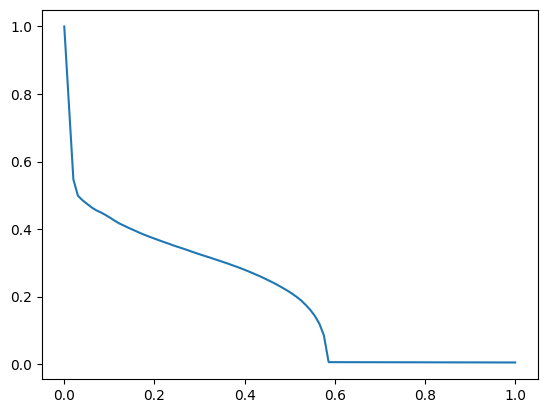

In [124]:
plt.plot(r_sampled, p_sampled)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f449b119300>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


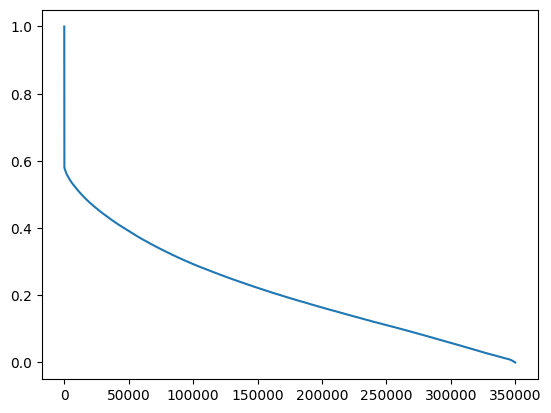

In [127]:
plt.plot(umaps)

In [128]:
len(umaps)

349852